# Урок 1 Структура

In [ ]:
import numpy as np
from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import tensorflow as tf

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [ ]:
def build_unet_model(num_classes):
   inputs = layers.Input(shape=(160,160,3))
   # энкодер
   # 1 - понижающая свёртка
   f1, p1 = downsample_block(inputs, 64)
   # 2 - понижающая свёртка
   f2, p2 = downsample_block(p1, 128)
   # 3 - понижающая свёртка
   f3, p3 = downsample_block(p2, 256)
   # 4 - понижающая свёртка
   f4, p4 = downsample_block(p3, 512)
   # 5 - бутылочное горлышко
   bottleneck = double_conv_block(p4, 1024)
   # декодер: расширение пути — повышение дискретизации
   # 6 - повышение дискретизации
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - повышение дискретизации
   u7 = upsample_block(u6, f3, 256)
   # 8 - повышение дискретизации
   u8 = upsample_block(u7, f2, 128)
   # 9 - повышение дискретизации
   u9 = upsample_block(u8, f1, 64)
   # выходы
   outputs = layers.Conv2D(num_classes, 3, padding="same", activation = "softmax")(u9)
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
unet_model = build_unet_model(3)

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 160, 160, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 160, 160, 64)         36928     ['conv2d_38[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 80, 80, 64)           0         ['conv2d_39[0][0]']           
 g2D)                                                                                         

In [ ]:
import keras.utils

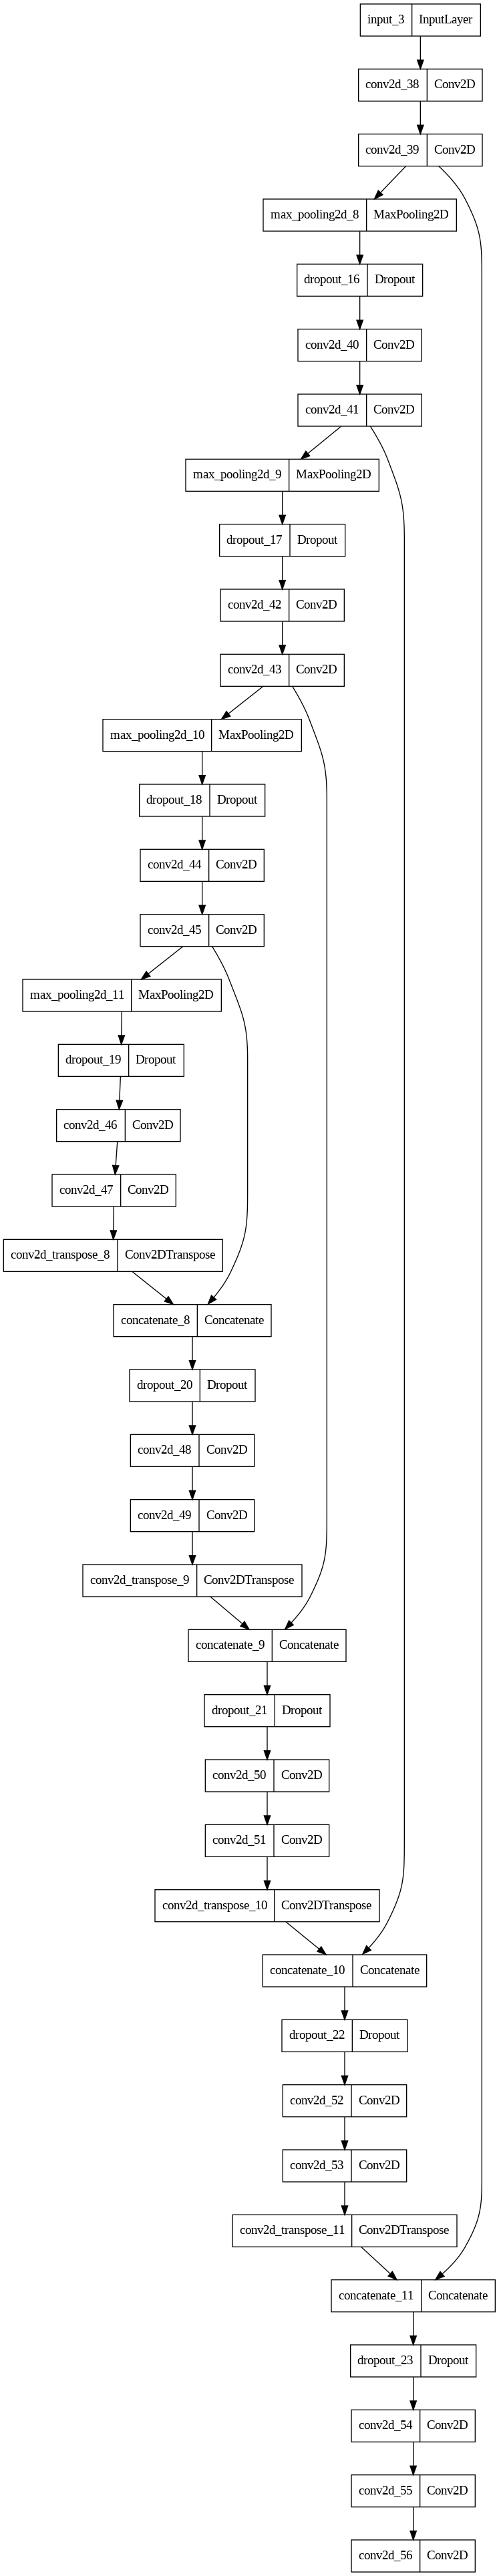

In [ ]:
keras.utils.plot_model(unet_model)

# Скачиваем данные

In [ ]:
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
!
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  31.4M      0  0:00:24  0:00:24 --:--:-- 34.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  10.9M      0  0:00:01  0:00:01 --:--:-- 10.9M



Подготовим пути входных изображений и целевые маски сегментации

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 2

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [ ]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

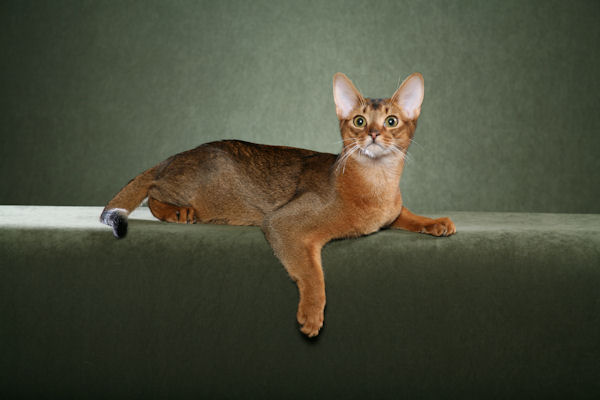

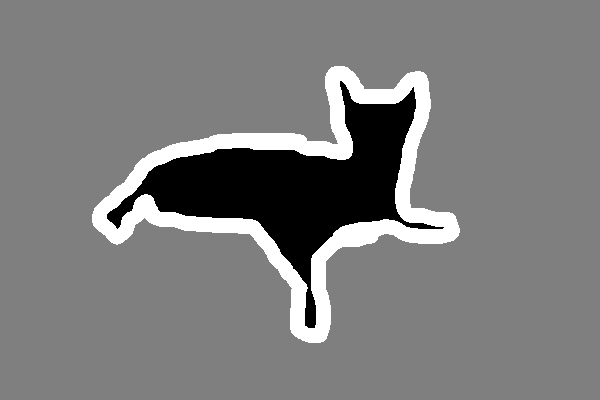

In [ ]:
# Отображаем самый первый рисунок и маску
display(Image(filename=input_img_paths[0]))
# Отображение версии автоконтрастности соответствующей цели (попиксельные категории)
img = ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)

Подготовьте набор данных для загрузки и векторизации пакетов данных

In [ ]:
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

In [ ]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Возвращает набор данных TF."""
    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Метки основной истины — 1, 2, 3. Вычтите единицу, чтобы получить 0, 1, 2
        target_img -= 1
        return input_img, target_img
    # Для более быстрой отладки ограничьте размер данных
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [ ]:
import random

limit = 10

In [ ]:
# Разделите наши пути img на обучающий и проверочный набор
val_samples = limit
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Создать экземпляр набора данных для каждого разделения
# Ограничьте входные файлы в `max_dataset_len` для ускорения времени обучения эпохи
# Удалите аргумент `max_dataset_len` при работе с полным набором данных
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=limit,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [ ]:
import sys

In [ ]:
sys.getsizeof(tf_io.read_file(train_input_img_paths[0]))

168

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 1), dtype=tf.uint8, name=None))>

In [ ]:
sys.getsizeof(train_dataset)

48

In [ ]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
epochs = 15
unet_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

Epoch 1/15
5/5 - 55s - loss: 122.4375 - accuracy: 0.4080 - val_loss: 30.7406 - val_accuracy: 0.6122 - 55s/epoch - 11s/step
Epoch 2/15
5/5 - 55s - loss: 21.0390 - accuracy: 0.4962 - val_loss: 4.6694 - val_accuracy: 0.3486 - 55s/epoch - 11s/step
Epoch 3/15
5/5 - 45s - loss: 5.0956 - accuracy: 0.3969 - val_loss: 2.2726 - val_accuracy: 0.3757 - 45s/epoch - 9s/step
Epoch 4/15
5/5 - 44s - loss: 2.1028 - accuracy: 0.4264 - val_loss: 1.5111 - val_accuracy: 0.4310 - 44s/epoch - 9s/step
Epoch 5/15
5/5 - 40s - loss: 1.4762 - accuracy: 0.4467 - val_loss: 1.2642 - val_accuracy: 0.4654 - 40s/epoch - 8s/step
Epoch 6/15
5/5 - 43s - loss: 1.2340 - accuracy: 0.4748 - val_loss: 1.1394 - val_accuracy: 0.5253 - 43s/epoch - 9s/step
Epoch 7/15
5/5 - 41s - loss: 1.1216 - accuracy: 0.5011 - val_loss: 1.0542 - val_accuracy: 0.5990 - 41s/epoch - 8s/step
Epoch 8/15
5/5 - 45s - loss: 1.0624 - accuracy: 0.5217 - val_loss: 1.0017 - val_accuracy: 0.6158 - 45s/epoch - 9s/step
Epoch 9/15
5/5 - 38s - loss: 1.0207 - accu

In [ ]:
from PIL import Image as Im

In [ ]:
def display_mask(i):
    """Быстрая утилита для отображения прогноза модели"""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    img = img.resize((500, 500), Im.LANCZOS)
    display(img)

In [ ]:
def check_one_image(i):
  # Отображение входного изображения
  display(Image(filename=val_input_img_paths[i]))

  # Отображение истинной маски
  img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
  display(img)

  # Отображение предсказанной маски
  display_mask(i)


In [ ]:
val_preds = unet_model.predict(valid_dataset)

5/5 [==============================] - 8s 1s/step


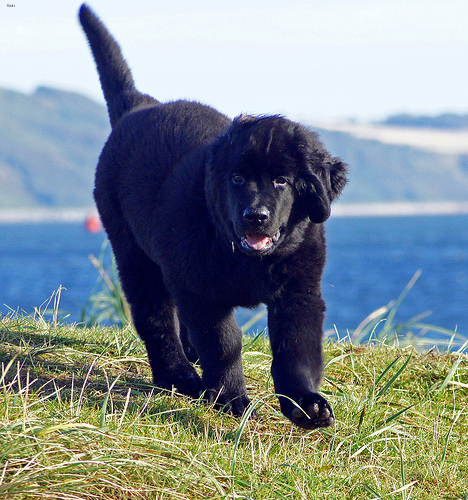

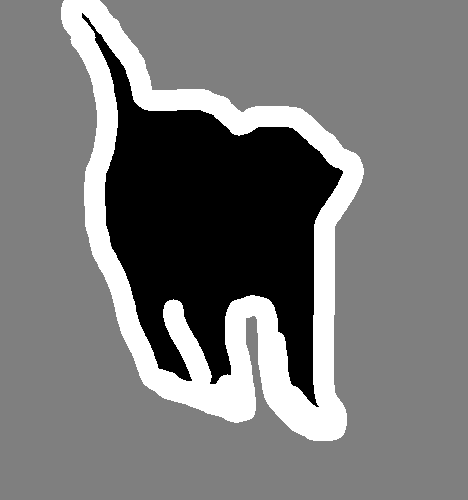

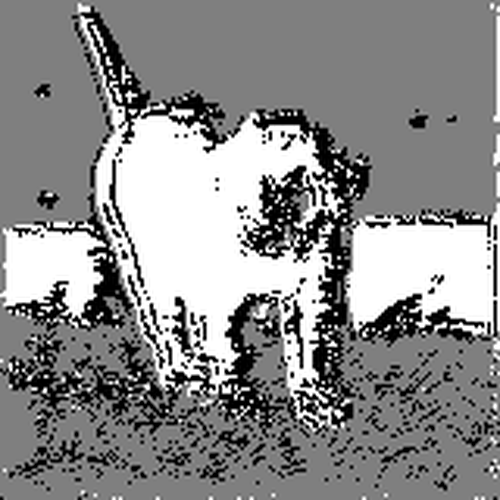

In [ ]:
check_one_image(0)

# второй вариант с одной эпохой и всеми примерами

In [ ]:
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype='uint8')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size,
                           color_mode='grayscale')
            y[j] = np.expand_dims(img, 2)
        return x, y

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        # Project residual
        residual = layers.Conv2D(
            filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(
        num_classes, 3, activation='sigmoid', padding='same')(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
model = get_model(img_size, 4)

In [ ]:
val_samples = 10
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(batch_size, img_size,
                       train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size,
                     val_input_img_paths, val_target_img_paths)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')



# Train the model, doing validation at the end of each epoch
epochs = 1  # In practice you need at least 15 epochs
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

3690/3690 [==============================] - 2040s 551ms/step - loss: 0.5796 - val_loss: 0.6722


In [ ]:
val_preds = unet_model.predict(val_gen)

5/5 [==============================] - 10s 1s/step


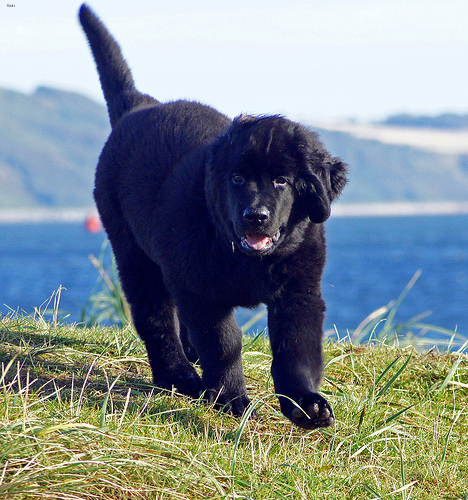

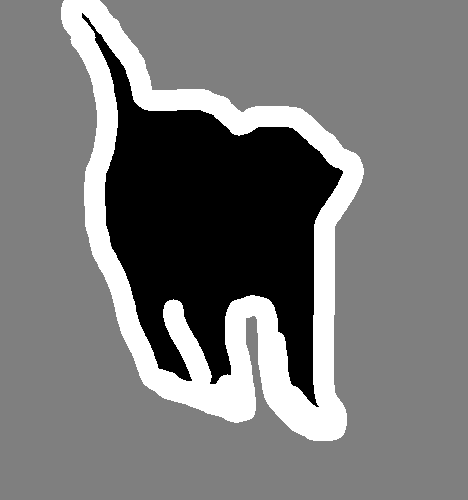

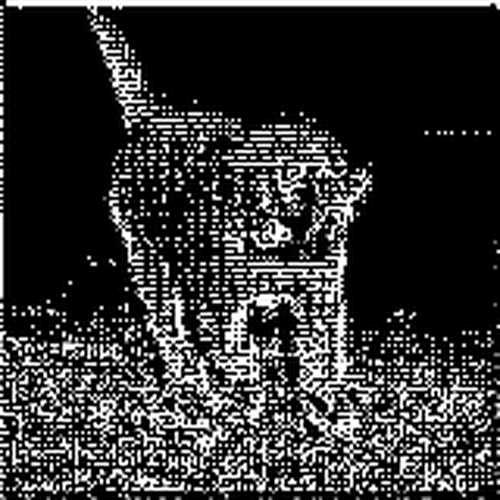

In [ ]:
check_one_image(0)

# Пробуем различные loss функции

In [ ]:
!pip install segmentation_models

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Возвращает набор данных TF."""
    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "float32")

        # Метки основной истины — 1, 2, 3. Вычтите единицу, чтобы получить 0, 1, 2
        target_img -= 1
        return input_img, target_img
    # Для более быстрой отладки ограничьте размер данных
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [ ]:
# Разделите наши пути img на обучающий и проверочный набор.
val_samples = limit
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Создать экземпляр набора данных для каждого разделения
# Ограничьте входные файлы в `max_dataset_len` для ускорения времени обучения эпохи.
# Удалите аргумент `max_dataset_len` при работе с полным набором данных.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=limit,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
model_dice_loss = build_unet_model(3)
model_dice_loss.compile(loss = dice_loss)
epochs = 3
model_dice_loss.fit(
    train_dataset,
    epochs=epochs,
    verbose=2,
)

Epoch 1/3
5/5 - 40s - loss: 72.7840 - 40s/epoch - 8s/step
Epoch 2/3
5/5 - 33s - loss: 95.1397 - 33s/epoch - 7s/step
Epoch 3/3
5/5 - 33s - loss: 95.1397 - 33s/epoch - 7s/step


In [ ]:
model_focal_loss = build_unet_model(3)
model_focal_loss.compile(loss = focal_loss)
epochs = 3
model_focal_loss.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

Epoch 1/3
5/5 - 45s - loss: -2.6466e+00 - val_loss: -2.6664e+00 - 45s/epoch - 9s/step
Epoch 2/3
5/5 - 45s - loss: -2.6673e+00 - val_loss: -2.6664e+00 - 45s/epoch - 9s/step
Epoch 3/3
5/5 - 46s - loss: -2.6673e+00 - val_loss: -2.6664e+00 - 46s/epoch - 9s/step


In [ ]:
model_total_loss = build_unet_model(3)
model_total_loss.compile(loss = total_loss)
epochs = 3
model_total_loss.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

Epoch 1/3
5/5 - 40s - loss: 70.1343 - val_loss: 87.6614 - 40s/epoch - 8s/step
Epoch 2/3
5/5 - 43s - loss: 92.4725 - val_loss: 87.6614 - 43s/epoch - 9s/step
Epoch 3/3
5/5 - 40s - loss: 92.4725 - val_loss: 87.6614 - 40s/epoch - 8s/step


# пробуем оптимизаторы различные

In [ ]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Возвращает набор данных TF."""
    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Метки основной истины — 1, 2, 3. Вычтите единицу, чтобы получить 0, 1, 2
        target_img -= 1
        return input_img, target_img
    # Для более быстрой отладки ограничьте размер данных
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [ ]:
# Разделите наши пути img на обучающий и проверочный набор.
val_samples = limit
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Создать экземпляр набора данных для каждого разделения
# Ограничьте входные файлы в `max_dataset_len` для ускорения времени обучения эпохи.
# Удалите аргумент `max_dataset_len` при работе с полным набором данных.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=limit,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
from tensorflow.keras import backend as K

In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    jac = (intersection + 1.) / (union - intersection + 1.)
    return K.mean(jac)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    return (2. * intersection + smooth) / (
                K.sum(y_true) + K.sum(y_pred) + smooth)

In [ ]:

# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# def dice_coef_loss(y_true, y_pred):
#     return -dice_coef(y_true, y_pred)

In [ ]:
unet_model = build_unet_model(3)
unet_model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                   metrics = [iou_coef])
epochs = 15
unet_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

Epoch 1/15
5/5 - 47s - loss: 52.8521 - iou_coef: 0.7639 - val_loss: 11.3938 - val_iou_coef: 0.7889 - 47s/epoch - 9s/step
Epoch 2/15
5/5 - 48s - loss: 14.0647 - iou_coef: 0.7639 - val_loss: 7.4264 - val_iou_coef: 0.7889 - 48s/epoch - 10s/step
Epoch 3/15
5/5 - 46s - loss: 7.4620 - iou_coef: 0.7639 - val_loss: 1.8883 - val_iou_coef: 0.7889 - 46s/epoch - 9s/step
Epoch 4/15
5/5 - 46s - loss: 3.0024 - iou_coef: 0.7639 - val_loss: 1.8148 - val_iou_coef: 0.7889 - 46s/epoch - 9s/step
Epoch 5/15
5/5 - 55s - loss: 2.3861 - iou_coef: 0.7639 - val_loss: 1.3318 - val_iou_coef: 0.7889 - 55s/epoch - 11s/step
Epoch 6/15
5/5 - 50s - loss: 1.5714 - iou_coef: 0.7639 - val_loss: 1.2266 - val_iou_coef: 0.7889 - 50s/epoch - 10s/step
Epoch 7/15
5/5 - 47s - loss: 1.2534 - iou_coef: 0.7639 - val_loss: 1.0755 - val_iou_coef: 0.7889 - 47s/epoch - 9s/step
Epoch 8/15
5/5 - 45s - loss: 1.1148 - iou_coef: 0.7639 - val_loss: 1.0485 - val_iou_coef: 0.7889 - 45s/epoch - 9s/step
Epoch 9/15
5/5 - 46s - loss: 1.0510 - iou_

In [ ]:
unet_model = build_unet_model(3)
unet_model.compile(optimizer='rmsprop',
                  loss="sparse_categorical_crossentropy",
                  metrics = [jaccard_coef, dice_coef])
epochs = 10
unet_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

Epoch 1/10
5/5 - 45s - loss: 997433.0000 - jaccard_coef: 0.2969 - dice_coef: 0.8519 - val_loss: 49.8362 - val_jaccard_coef: 0.3051 - val_dice_coef: 0.8792 - 45s/epoch - 9s/step
Epoch 2/10
5/5 - 43s - loss: 45.9208 - jaccard_coef: 0.2969 - dice_coef: 0.8519 - val_loss: 7.1660 - val_jaccard_coef: 0.3051 - val_dice_coef: 0.8792 - 43s/epoch - 9s/step
Epoch 3/10
5/5 - 43s - loss: 15.3760 - jaccard_coef: 0.2969 - dice_coef: 0.8519 - val_loss: 3.6556 - val_jaccard_coef: 0.3051 - val_dice_coef: 0.8792 - 43s/epoch - 9s/step
Epoch 4/10
5/5 - 43s - loss: 9.3813 - jaccard_coef: 0.2969 - dice_coef: 0.8519 - val_loss: 2.8104 - val_jaccard_coef: 0.3051 - val_dice_coef: 0.8792 - 43s/epoch - 9s/step
Epoch 5/10
5/5 - 43s - loss: 7.3887 - jaccard_coef: 0.2969 - dice_coef: 0.8519 - val_loss: 2.3609 - val_jaccard_coef: 0.3051 - val_dice_coef: 0.8792 - 43s/epoch - 9s/step
Epoch 6/10
5/5 - 43s - loss: 5.4187 - jaccard_coef: 0.2969 - dice_coef: 0.8519 - val_loss: 1.6312 - val_jaccard_coef: 0.3051 - val_dice_c

In [ ]:
tf.data.experimental.enable_debug_mode()

In [ ]:
val_preds = unet_model.predict(val_gen)

5/5 [==============================] - 10s 2s/step


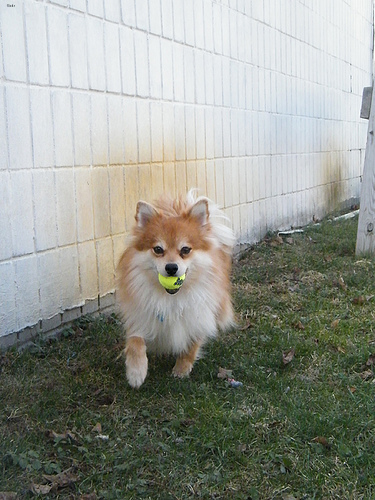

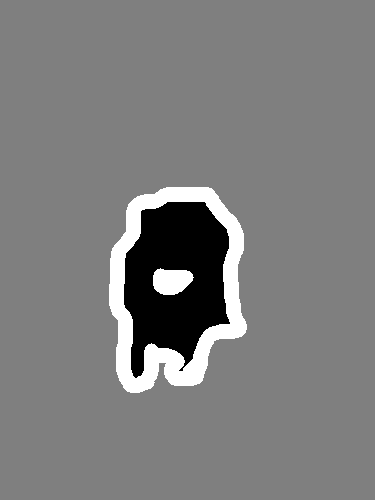

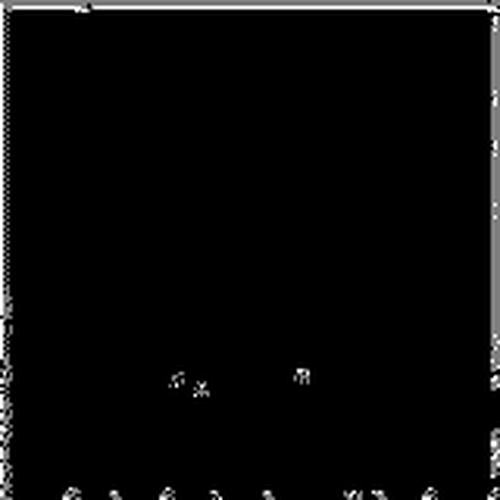

In [ ]:
check_one_image(0)